# Predict Electricity Consumption using Time Series Analysis

## What is Time Series analysis?

Time series forecasting is a technique for the prediction of events indexed by time. This techniques predict future events by analyzing the trends of the past, on the assumption that future trends will hold similar to historical trends.


#### Time series forecasting is performed in a variety of applications including

-  Weather forecasting
-  Earthquake prediction
-  Astronomy
-  Statistics
-  Finance



#### There are two main goals of time series analysis: 
- identifying the nature of the phenomenon.
- forecasting the future values of the time series variable. 

Both of these goals require that the pattern the time series data is identified and decomposed in its components. Once the pattern is established, we can interpret and then extrapolate it to predict future events.


## Stages in Time Series Forecasting

The main steps of solving a time series problem are as follows:

**1. Visualizing time series**

In this step, we try to visualize the series. We try to identify all the underlying patterns related to the series like trend and seasonality. Do not worry about these terms right now, as we will discuss them during implementation. You can say that this is more a type of exploratory analysis of time series data.


**2. Stationarising time series**

`A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.`
Most statistical forecasting methods are based on the assumption that the time series is stationary. We can make a time series into a stationairy time series by applying mathematical transformations to it.A stationary time series has a constant mean, median std deviaiton across its whole time period.


**3. Finding the best parameters for our model**

We need to find optimal parameters for the forecasting models once we have a stationary series. These parameters come from the ACF and PACF plots. Hence, this stage is more about plotting ACF and PACF graphs and finding optimal model parameters based on them.


**4. Fitting model**

Once we have our optimal model parameters, we can fit an ARIMA model to learn the pattern of the series.


**5. Predictions**

After fitting our model, we will be predicting the future in this stage. Since we are now familiar with a basic flow of solving a time series problem, let us get to the implementation.



In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # special style template for matplotlib, highly useful for visualizing time series data
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7


### Load the dataset

In [3]:
df = pd.read_csv('https://github.com/lalit-kumr/demand-estimation-case-study/raw/main/Electricity%20Consumption.csv')
df

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


Now, Define column names, drop nulls, convert Date to DateTime format and make Date as an index.

In [4]:
df.columns=['Date', 'Consumption']
df=df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) #set date as index
df.head()

,Consumption
Date,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107


### 1.Visualizing the time series.

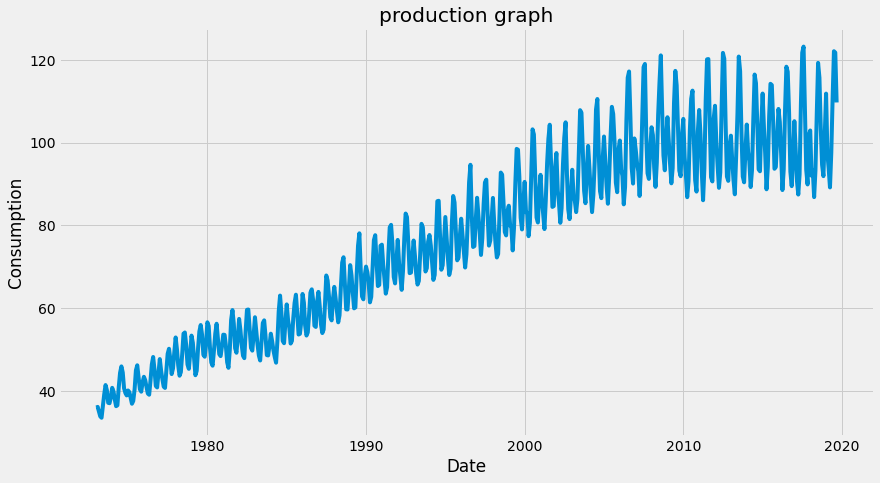

In [5]:
# Line plot
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(df)



# analysis of the graph:the mean is not constant in this case as we can clearly see an upward trend thus the series is not stationary

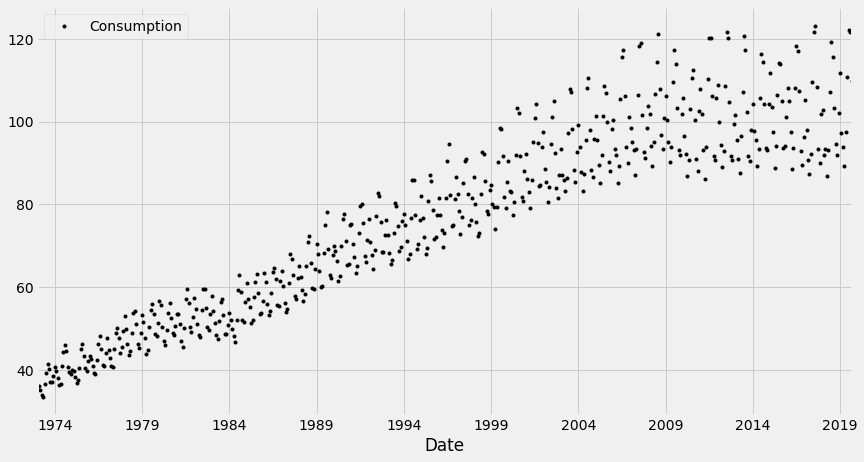

In [6]:
# Scatter plot
df.plot(style='k.')
plt.show()

<AxesSubplot:ylabel='Density'>

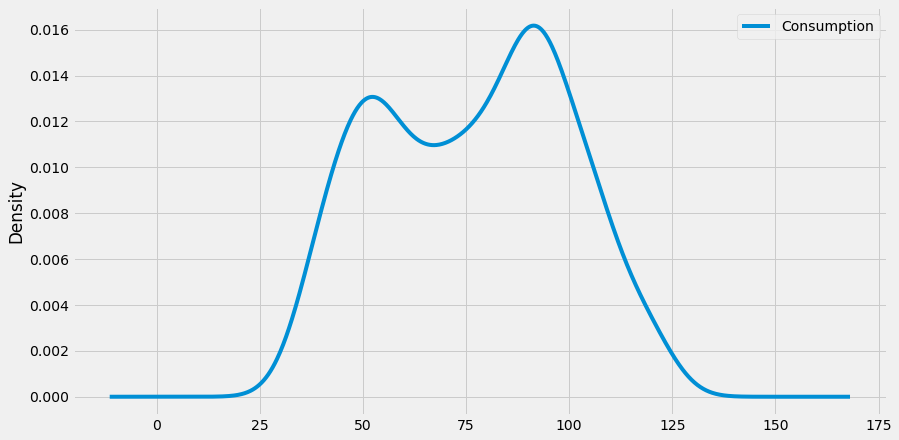

In [7]:
# KDE Plot
df.plot(kind='kde')

#### **Decomposing a Time series:**
- A time series consists of 4 components:
    - Trend
    - Seasonality
    - Cyclicity
    - Noise

**Trend**: Trend is the overall incresase or decrease overtime in a time series. It can be positive in nature(called uptrend) or negative in nature(downtrend). It can be of linear, log or any other form.

**Seasonality**: The repeating short-term cycle in the series are called seasons. Usually we take seasons as phenomena that repeat yearly.

**Cyclicity** : Cyclicity refers to long term patterns that occur on a scale of multiple years to decades. for exapmle the US is said to have recovered from the 2008 downturn  in 2016. so this overall change in its GDP will come under cyclicity part.

**Noise**: The random variation in the series.

In order to perform a time series analysis we need to seperate trend, seasons, cyclicity and noise from our series. The resultant series will become stationary through this process.

So let us decompose our time series

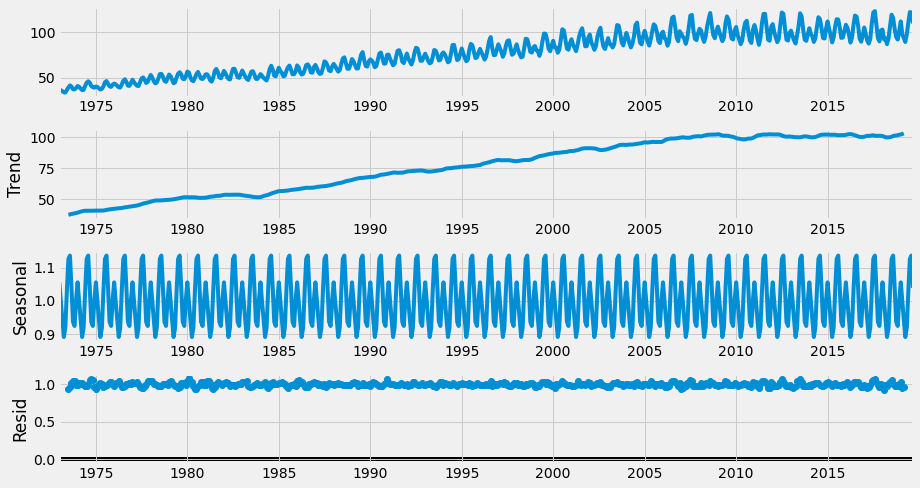

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()


# Observations: Clearly, there is an upward trend and a recurring event where electricity consumption shoots maximum every year.

### 2. Stationarising the time series.


Now we need to stationarize the time series. For this we use the ADFuller test.

#### ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is a statistical tests used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:


**Null Hypothesis:** The series has a unit root (value of a =1) i.e series is non-stationary and has a time dependent structure.


**Alternate Hypothesis:** The series has no unit root.series is stationary


If we fail to reject the null hypothesis, we can say that the series is non-stationary. 


If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


The following function is one that can plot a series with its rolling mean and standard deviation.

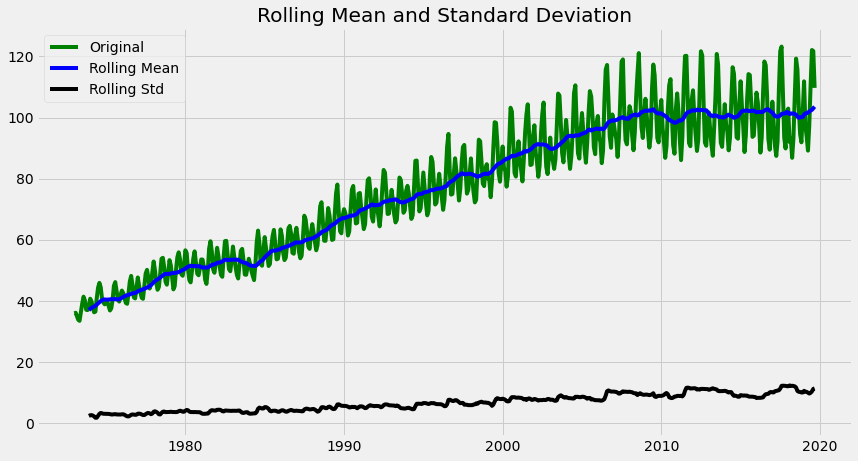

Results of dickey fuller test
Test Statistics                 -1.740593
p-value                          0.410328
No. of lags used                15.000000
Number of observations used    545.000000
critical value (1%)             -3.442406
critical value (5%)             -2.866858
critical value (10%)            -2.569602
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='green',label='Original')
    plt.plot(rolmean, color='blue', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['Consumption'])
    # output for adft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df)

- Our p-value is greater than 0.05 so we cannot reject the Null hypothesis. ***So the series is non-stationary.***


- To get a stationary series, we need to eliminate the trend and seasonality from the series.

- We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past n(here n=12) months and giving a mean consumption value at every point further ahead in series.

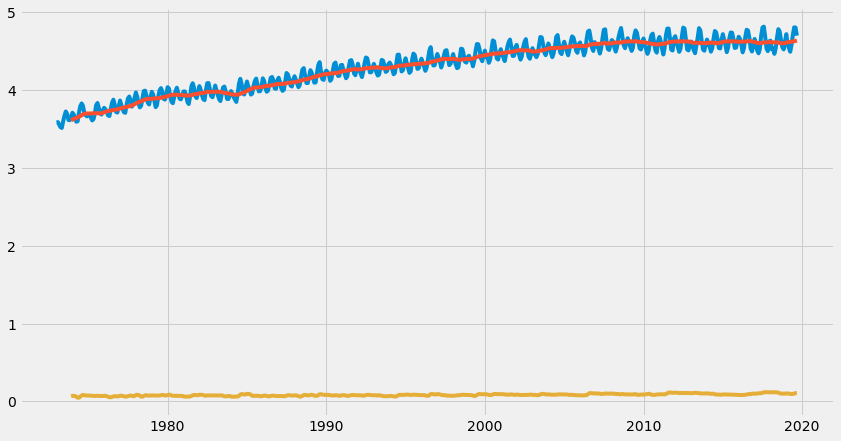

In [10]:
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg,label = 'Rolling mean')
plt.plot(std_dev,label = 'Rolling Std')
plt.show()

After finding the mean, we take the difference of the series and the mean at every point in the series.

This way, we eliminate trends out of a series and obtain a more stationary series.

In [26]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again. We have to perform this function every time to check whether the data is stationary or not.

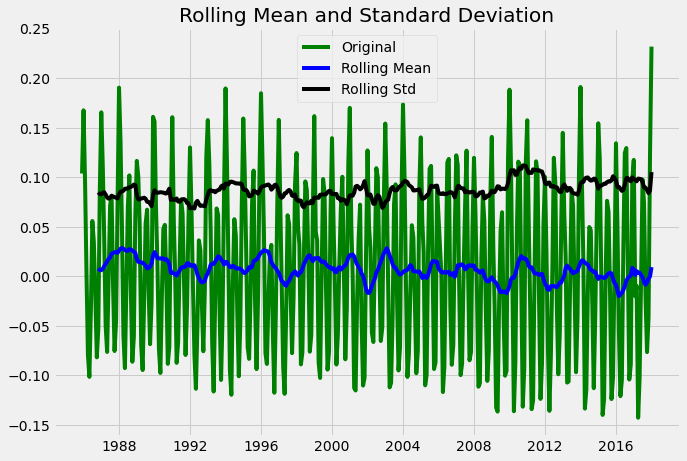

Results of dickey fuller test
Test Statistics                 -5.211586
p-value                          0.000008
No. of lags used                15.000000
Number of observations used    370.000000
critical value (1%)             -3.448148
critical value (5%)             -2.869383
critical value (10%)            -2.570948
dtype: float64


In [22]:
test_stationarity(df_log_moving_avg_diff)

From the above graph, we observed that the series has become stationarity.

Now we need to check the weighted average, to understand the trend of the data in time series. Take the previous log data and to perform the following operation.

In [23]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()

The exponential moving average (EMA) is a weighted average of the last n prices, where the weighting decreases exponentially with each previous price/period. In other words, the formula gives recent prices more weight than past prices.

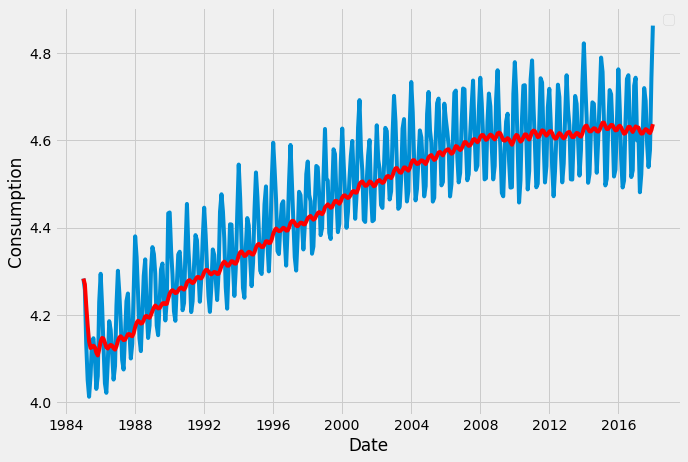

In [24]:
plt.plot(df_log)
plt.plot(weighted_average, color='red')
plt.xlabel("Date")
plt.ylabel("Consumption")
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
plt.legend()
plt.show(block =False)

Previously we subtracted df_log with moving average, now take the same df_log and subtract with weighted_average and perform the Dickey-Fuller test (ADFT) once again.

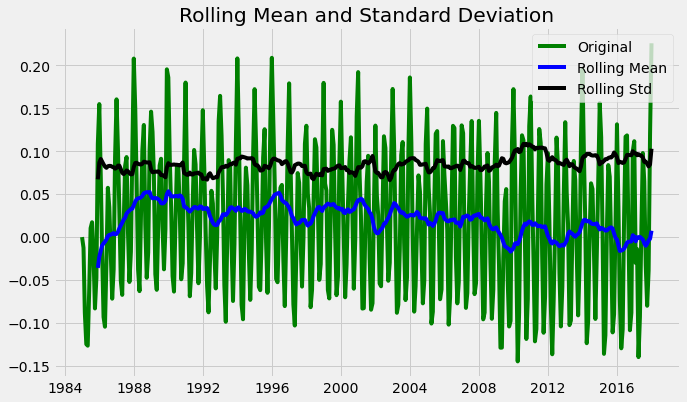

Results of dickey fuller test
Test Statistics                 -3.251531
p-value                          0.017189
No. of lags used                15.000000
Number of observations used    381.000000
critical value (1%)             -3.447631
critical value (5%)             -2.869156
critical value (10%)            -2.570827
dtype: float64


In [25]:
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

From the above graph, we observed that the data attained stationarity. We also see that the test statistics and critical value is relatively equal.

There can be cases when there is a high seasonality in the data. In those cases, just removing the trend will not help much. We need to also take care of the seasonality in the series. One such method for this task is differencing.


Differencing is a method of transforming a time series dataset.
It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.


Differencing is performed by subtracting the previous observation from the current observation.

Perform the Dickey-Fuller test (ADFT) once again.

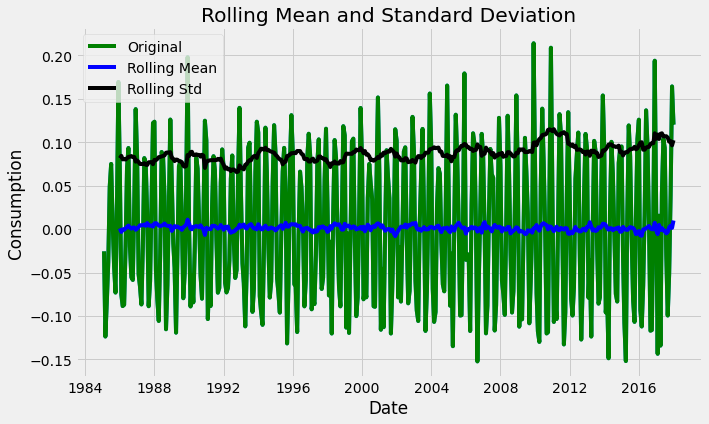

Results of dickey fuller test
Test Statistics               -6.748333e+00
p-value                        2.995161e-09
No. of lags used               1.400000e+01
Number of observations used    3.810000e+02
critical value (1%)           -3.447631e+00
critical value (5%)           -2.869156e+00
critical value (10%)          -2.570827e+00
dtype: float64


In [26]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)

#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

The next step is to perform decomposition which provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.

In [27]:
!pip install chart_studio

     |████████████████████████████████| 64 kB 1.4 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


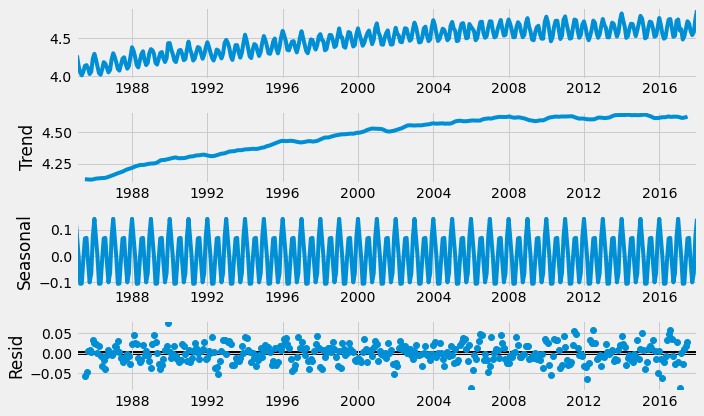

In [28]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_log, model='additive', freq = 12)
result.plot()
plt.show()


Finally, perform the Dickey-Fuller test (ADFT) once again.

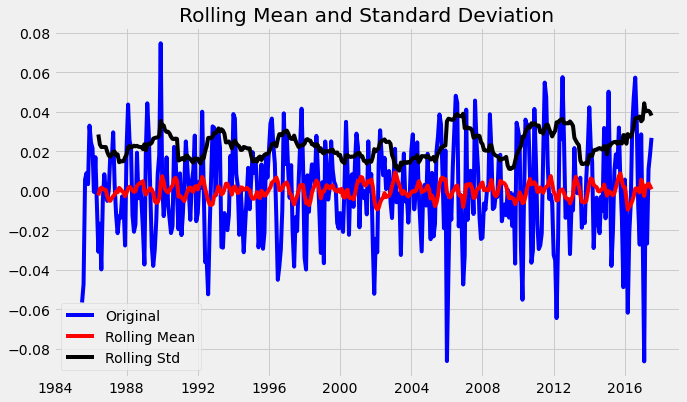

In [29]:
def test_stationarity_final(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)



trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)
test_stationarity_final(residual)

After the decomposition, if we look at the residual then we have clearly a flat line for both mean and standard deviation. We have got our stationary series and now we can move to find the best parameters for our model.

### 3. Finding the best parameters for our model

Before we go on to build our forecasting model, we need to determine optimal parameters for our model. For those optimal parameters, we need ACF and PACF plots.


A nonseasonal ARIMA model is classified as an “ARIMA(p,d,q)” model, where:

p → Number of autoregressive terms,
d → Number of nonseasonal differences needed for stationarity, and
q → Number of lagged forecast errors in the prediction equation.


Values of p and q come through ACF and PACF plots. So let us understand both ACF and PACF!

#### Autocorrelation Function(ACF)

Statistical correlation summarizes the strength of the relationship between two variables. Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.


We can calculate the correlation for time series observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.


A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.


#### Partial Autocorrelation Function(PACF)

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.


The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.


The autocorrelation for observation and observation at a prior time step is comprised of both the direct correlation and indirect correlations. It is these indirect correlations that the partial autocorrelation function seeks to remove.


Below code plots, both ACF and PACF plots for us:

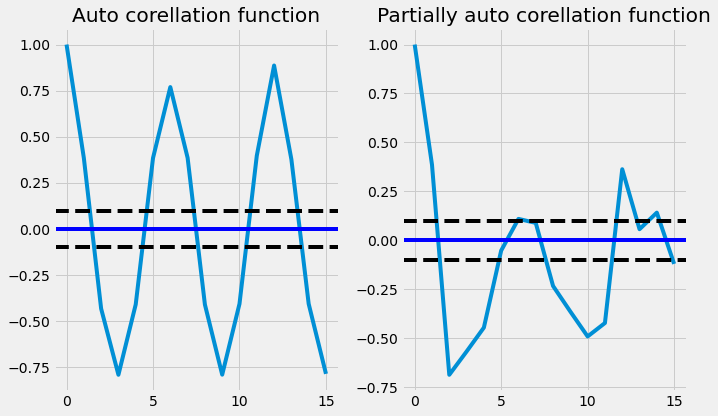

In [30]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(df_log_diff, nlags=15)
pacf= pacf(df_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

### 4. Fitting model

In order to find the p and q values from the above graphs, we need to check, where the graph cuts off the origin or drops to zero for the first time from the above graphs the p and q values are merely close to 3 where the graph cuts off the origin ( draw the line to x-axis) now we have p,d,q values. So now we can substitute in the ARIMA model and let's see the output.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RSS : 0.522683


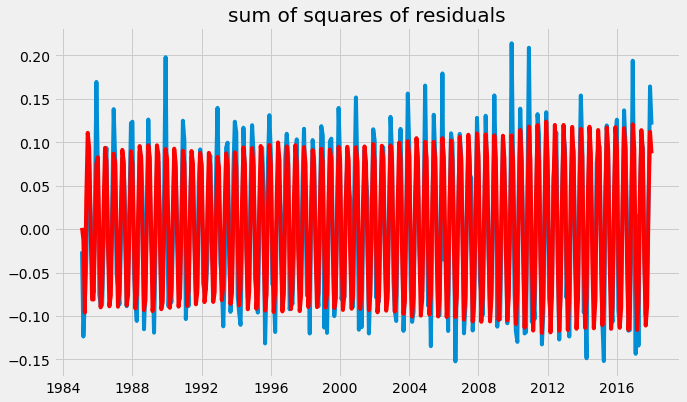

In [31]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(3,1,3))
result_AR = model.fit(disp = 0)
plt.plot(df_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-df_log_diff["Consumption"])**2))

Less the RSS value, the more effective the model is. You check with (2,1,0),(3,1,1), etc to look for the smallest values of RSS.

### 5. Predictions

The following code helps us forcast the next 6 years of values.

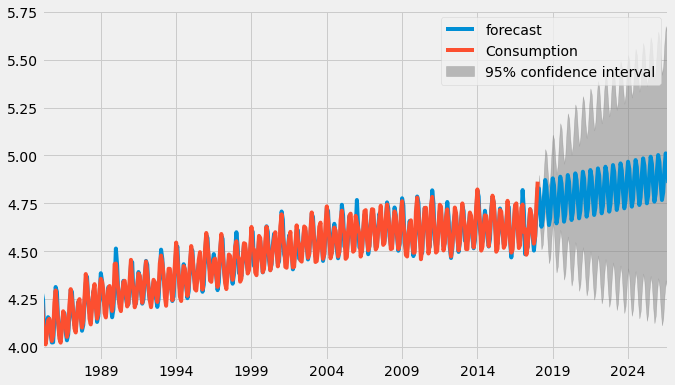

In [32]:
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=300)

From the above graph, we calculated the future predictions till 2024 the greyed out area is the confidence interval that means the predictions will not cross that area.